# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from pytz import timezone
from datetime import datetime
import time
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
ind_time = datetime.now(timezone("Asia/Kolkata"))
to_time = int(time.mktime(ind_time.timetuple()))

lat = '18.5204'
lon = '73.8567'
start = '1609456500'
end = str(to_time)
appid = 'aa5ba39ad21a567b7e57153705a52caf'

response_API = requests.get('http://api.openweathermap.org/data/2.5/air_pollution/history?lat='+lat+'&lon='+lon+'&start='+start+'&end='+end+'&appid='+appid)
print(response_API.status_code) # If code response is 200 then SUCCESS
parse_data = response_API.text

data = json.loads(parse_data)
df = pd.json_normalize(data['list'])
df['dt'] = pd.to_datetime(df['dt'],unit='s')
df.rename(columns = {'dt':'Date',
                     'main.aqi':'AQIclass',
                     'components.co':'CO',
                     'components.no':'NO',
                     'components.no2':'NO2',
                     'components.o3':'O3',
                     'components.so2':'SO2',
                     'components.pm2_5':'PM25',
                     'components.pm10':'PM10',
                     'components.nh3':'NH3'}, inplace = True)

df['NOx'] = df['NO'] + df['NO2']
df = df.drop(['NO','NO2'], axis=1)
df['CO'] = df['CO']/1000
df

200


,Date,AQIclass,CO,O3,SO2,PM25,PM10,NH3,NOx
0,2021-01-01 00:00:00,5,0.93460,6.08,9.18,97.12,112.47,13.81,26.25
1,2021-01-01 01:00:00,5,1.09482,2.17,12.16,107.68,124.92,14.95,33.54
2,2021-01-01 02:00:00,5,1.52206,0.06,17.41,128.68,150.54,17.48,52.20
3,2021-01-01 03:00:00,5,1.81580,0.96,20.98,136.64,159.98,17.99,70.56
4,2021-01-01 04:00:00,5,1.34850,12.16,23.13,107.91,124.90,16.47,53.48
...,...,...,...,...,...,...,...,...,...
21352,2023-06-20 16:00:00,1,0.27371,28.25,4.95,8.99,14.57,2.00,6.18
21353,2023-06-20 17:00:00,2,0.27371,24.68,4.77,10.21,15.88,2.00,6.28
21354,2023-06-20 18:00:00,1,0.26035,24.32,4.05,9.93,14.82,1.69,5.42
21355,2023-06-20 19:00:00,1,0.24366,25.03,3.43,8.49,12.58,1.47,4.04


In [3]:
df["PM10_24hr_avg"] = df["PM10"].rolling(window = 24, min_periods = 16).mean().values
df["PM25_24hr_avg"] = df["PM25"].rolling(window = 24, min_periods = 16).mean().values
df["SO2_24hr_avg"] = df["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["NOx_24hr_avg"] = df["NOx"].rolling(window = 24, min_periods = 16).mean().values
df["NH3_24hr_avg"] = df["NH3"].rolling(window = 24, min_periods = 16).mean().values
df["CO_8hr_max"] = df["CO"].rolling(window = 8, min_periods = 1).max().values
df["O3_8hr_max"] = df["O3"].rolling(window = 8, min_periods = 1).max().values

In [4]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM25_SubIndex"] = df["PM25_24hr_avg"].apply(lambda x: get_PM25_subindex(x))

In [5]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))

In [6]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

df["SO2_SubIndex"] = df["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))

In [7]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NOx_SubIndex"] = df["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))

In [8]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

df["NH3_SubIndex"] = df["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))

In [9]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

df["CO_SubIndex"] = df["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

In [10]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

df["O3_SubIndex"] = df["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))

In [11]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM25_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["SO2_SubIndex"] > 0).astype(int) + \
                (df["NOx_SubIndex"] > 0).astype(int) + \
                (df["NH3_SubIndex"] > 0).astype(int) + \
                (df["CO_SubIndex"] > 0).astype(int) + \
                (df["O3_SubIndex"] > 0).astype(int)

df["AQI_calculated"] = round(df[["PM25_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                 "NH3_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))

df.loc[df["PM25_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df
#df[~df.AQI_calculated.isna()].head(13)

,Date,AQIclass,CO,O3,SO2,PM25,PM10,NH3,NOx,PM10_24hr_avg,...,PM25_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2021-01-01 00:00:00,5,0.93460,6.08,9.18,97.12,112.47,13.81,26.25,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,46.7300,6.08,2,NaN,NaN
1,2021-01-01 01:00:00,5,1.09482,2.17,12.16,107.68,124.92,14.95,33.54,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,54.7410,6.08,2,NaN,NaN
2,2021-01-01 02:00:00,5,1.52206,0.06,17.41,128.68,150.54,17.48,52.20,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,76.1030,6.08,2,NaN,NaN
3,2021-01-01 03:00:00,5,1.81580,0.96,20.98,136.64,159.98,17.99,70.56,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,90.7900,6.08,2,NaN,NaN
4,2021-01-01 04:00:00,5,1.34850,12.16,23.13,107.91,124.90,16.47,53.48,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,90.7900,12.16,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21352,2023-06-20 16:00:00,1,0.27371,28.25,4.95,8.99,14.57,2.00,6.18,11.699583,...,12.046528,11.699583,4.461458,5.079688,0.410938,13.6855,51.50,7,52.0,Satisfactory
21353,2023-06-20 17:00:00,2,0.27371,24.68,4.77,10.21,15.88,2.00,6.28,11.760000,...,12.209722,11.760000,4.486458,5.121354,0.408646,13.6855,49.35,7,49.0,Good
21354,2023-06-20 18:00:00,1,0.26035,24.32,4.05,9.93,14.82,1.69,5.42,11.835833,...,12.404861,11.835833,4.501563,5.132292,0.406771,13.6855,49.35,7,49.0,Good
21355,2023-06-20 19:00:00,1,0.24366,25.03,3.43,8.49,12.58,1.47,4.04,11.884167,...,12.543750,11.884167,4.514062,5.122917,0.405417,13.6855,48.64,7,49.0,Good


<Axes: >

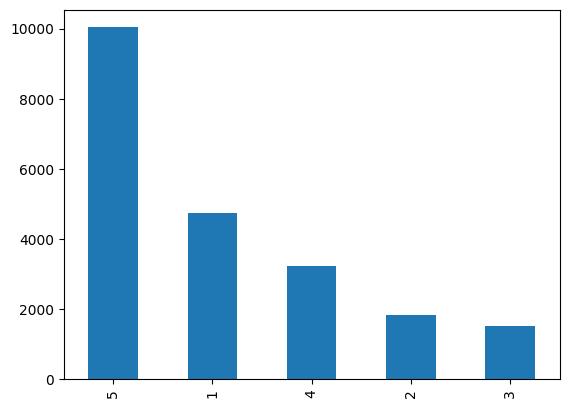

In [12]:
df['AQIclass'].value_counts().plot(kind='bar')

<Axes: >

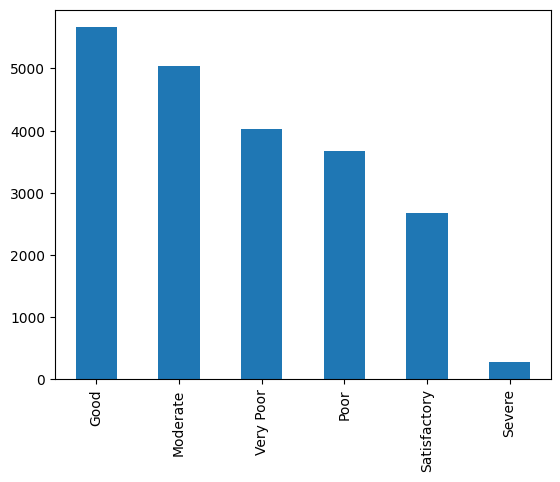

In [13]:
df['AQI_bucket_calculated'].value_counts().plot(kind='bar')

In [14]:
data = df.copy()
data = data.set_index('Date')
data

,AQIclass,CO,O3,SO2,PM25,PM10,NH3,NOx,PM10_24hr_avg,PM25_24hr_avg,...,PM25_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,5,0.93460,6.08,9.18,97.12,112.47,13.81,26.25,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,46.7300,6.08,2,NaN,NaN
2021-01-01 01:00:00,5,1.09482,2.17,12.16,107.68,124.92,14.95,33.54,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,54.7410,6.08,2,NaN,NaN
2021-01-01 02:00:00,5,1.52206,0.06,17.41,128.68,150.54,17.48,52.20,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,76.1030,6.08,2,NaN,NaN
2021-01-01 03:00:00,5,1.81580,0.96,20.98,136.64,159.98,17.99,70.56,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,90.7900,6.08,2,NaN,NaN
2021-01-01 04:00:00,5,1.34850,12.16,23.13,107.91,124.90,16.47,53.48,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,90.7900,12.16,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-20 16:00:00,1,0.27371,28.25,4.95,8.99,14.57,2.00,6.18,11.699583,7.227917,...,12.046528,11.699583,4.461458,5.079688,0.410938,13.6855,51.50,7,52.0,Satisfactory
2023-06-20 17:00:00,2,0.27371,24.68,4.77,10.21,15.88,2.00,6.28,11.760000,7.325833,...,12.209722,11.760000,4.486458,5.121354,0.408646,13.6855,49.35,7,49.0,Good
2023-06-20 18:00:00,1,0.26035,24.32,4.05,9.93,14.82,1.69,5.42,11.835833,7.442917,...,12.404861,11.835833,4.501563,5.132292,0.406771,13.6855,49.35,7,49.0,Good


In [15]:
#!pip install pandas_profiling --quiet
#import pandas_profiling
#profile = data.profile_report(title="EDA", explorative = True)
#profile.to_file(output_file="EDA.html")
#from google.colab import files
#files.download('EDA.html')

In [16]:
data = data.dropna()
data

,AQIclass,CO,O3,SO2,PM25,PM10,NH3,NOx,PM10_24hr_avg,PM25_24hr_avg,...,PM25_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 15:00:00,5,2.13623,0.01,26.94,132.48,164.82,27.87,84.93,108.865625,92.326875,...,207.756250,105.910417,24.001563,52.304688,3.565781,101.702875,100.205882,7,208.0,Poor
2021-01-01 16:00:00,5,2.24304,0.00,24.32,146.23,185.05,29.39,85.30,113.347059,95.497647,...,218.325490,108.898039,24.377941,55.500000,3.788235,103.038000,98.710000,7,218.0,Poor
2021-01-01 17:00:00,5,2.24304,0.00,20.03,151.92,196.23,23.31,81.81,117.951667,98.632222,...,228.774074,111.967778,24.414583,58.097917,3.901528,103.038000,77.960000,7,229.0,Poor
2021-01-01 18:00:00,5,1.92261,0.00,12.88,134.82,181.81,13.55,72.14,121.312632,100.536842,...,235.122807,114.208421,23.976974,59.786184,3.874474,103.038000,50.070000,7,235.0,Poor
2021-01-01 19:00:00,5,1.45531,0.01,7.15,108.64,152.64,8.11,57.01,122.879000,100.942000,...,236.473333,115.252667,23.225000,60.360000,3.782125,103.038000,23.600000,7,236.0,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-20 16:00:00,1,0.27371,28.25,4.95,8.99,14.57,2.00,6.18,11.699583,7.227917,...,12.046528,11.699583,4.461458,5.079688,0.410938,13.685500,51.500000,7,52.0,Satisfactory
2023-06-20 17:00:00,2,0.27371,24.68,4.77,10.21,15.88,2.00,6.28,11.760000,7.325833,...,12.209722,11.760000,4.486458,5.121354,0.408646,13.685500,49.350000,7,49.0,Good
2023-06-20 18:00:00,1,0.26035,24.32,4.05,9.93,14.82,1.69,5.42,11.835833,7.442917,...,12.404861,11.835833,4.501563,5.132292,0.406771,13.685500,49.350000,7,49.0,Good


In [17]:
timeseriesdf = data[['AQI_calculated']]
timeseriesdf

,AQI_calculated
Date,
2021-01-01 15:00:00,208.0
2021-01-01 16:00:00,218.0
2021-01-01 17:00:00,229.0
2021-01-01 18:00:00,235.0
2021-01-01 19:00:00,236.0
...,...
2023-06-20 16:00:00,52.0
2023-06-20 17:00:00,49.0
2023-06-20 18:00:00,49.0


In [18]:
timeseriessq = data['AQI_calculated']
timeseriessq

Date
2021-01-01 15:00:00    208.0
2021-01-01 16:00:00    218.0
2021-01-01 17:00:00    229.0
2021-01-01 18:00:00    235.0
2021-01-01 19:00:00    236.0
                       ...  
2023-06-20 16:00:00     52.0
2023-06-20 17:00:00     49.0
2023-06-20 18:00:00     49.0
2023-06-20 19:00:00     49.0
2023-06-20 20:00:00     46.0
Name: AQI_calculated, Length: 21342, dtype: float64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21342 entries, 2021-01-01 15:00:00 to 2023-06-20 20:00:00
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AQIclass               21342 non-null  int64  
 1   CO                     21342 non-null  float64
 2   O3                     21342 non-null  float64
 3   SO2                    21342 non-null  float64
 4   PM25                   21342 non-null  float64
 5   PM10                   21342 non-null  float64
 6   NH3                    21342 non-null  float64
 7   NOx                    21342 non-null  float64
 8   PM10_24hr_avg          21342 non-null  float64
 9   PM25_24hr_avg          21342 non-null  float64
 10  SO2_24hr_avg           21342 non-null  float64
 11  NOx_24hr_avg           21342 non-null  float64
 12  NH3_24hr_avg           21342 non-null  float64
 13  CO_8hr_max             21342 non-null  float64
 14  O3_8hr_max         

# Visualisation

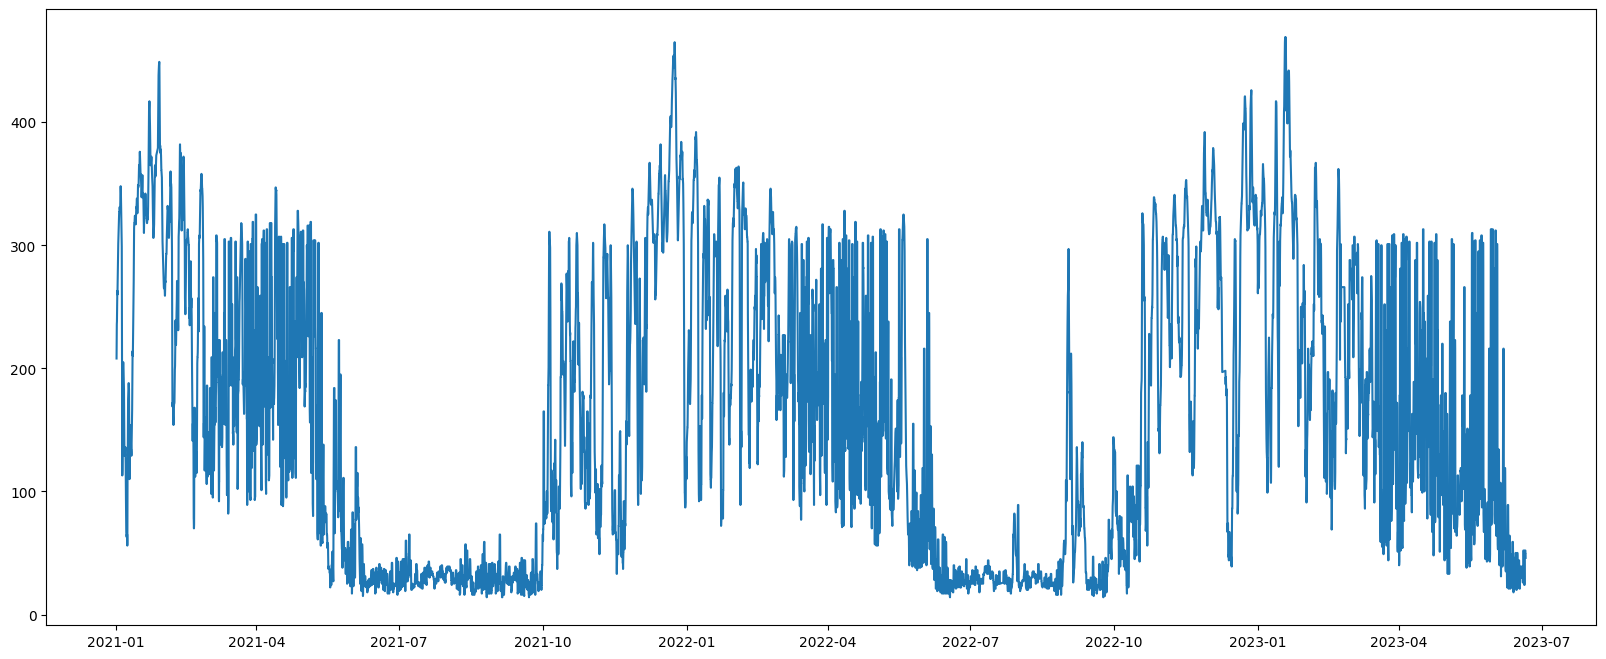

In [20]:
plt.figure(figsize = (20,8))
plt.plot(data.AQI_calculated)

#### Histogram and Density Plots

#### Box and Whisker Plots by Interval

In [21]:
# create a boxplot of yearly data
databoxplot = data
databoxplot['Date'] = databoxplot.index.astype(str)
new = databoxplot['Date'].str.split(' ',expand=True)
databoxplot['Date'] = new[0]
databoxplot = databoxplot[['Date','AQI_calculated']]
databoxplot['year'] = databoxplot['Date'].str[:4].astype(int)
databoxplot['date1'] = databoxplot['Date'].str[5:]
databoxplot

,Date,AQI_calculated,year,date1
Date,,,,
2021-01-01 15:00:00,2021-01-01,208.0,2021,01-01
2021-01-01 16:00:00,2021-01-01,218.0,2021,01-01
2021-01-01 17:00:00,2021-01-01,229.0,2021,01-01
2021-01-01 18:00:00,2021-01-01,235.0,2021,01-01
2021-01-01 19:00:00,2021-01-01,236.0,2021,01-01
...,...,...,...,...
2023-06-20 16:00:00,2023-06-20,52.0,2023,06-20
2023-06-20 17:00:00,2023-06-20,49.0,2023,06-20
2023-06-20 18:00:00,2023-06-20,49.0,2023,06-20


In [22]:
databoxplot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21342 entries, 2021-01-01 15:00:00 to 2023-06-20 20:00:00
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            21342 non-null  object 
 1   AQI_calculated  21342 non-null  float64
 2   year            21342 non-null  int64  
 3   date1           21342 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 833.7+ KB


In [23]:
years = pd.pivot_table(databoxplot,index = 'date1', values = 'AQI_calculated',columns='year', aggfunc = sum)

years

year,2021,2022,2023
date1,,,
01-01,2087.0,4065.0,6802.0
01-02,6827.0,4983.0,7652.0
01-03,7845.0,5375.0,8097.0
01-04,7955.0,7724.0,8500.0
01-05,4174.0,8439.0,6807.0
...,...,...,...
12-27,8636.0,9910.0,NaN
12-28,9020.0,8242.0,NaN
12-29,8367.0,7678.0,NaN


<Axes: >

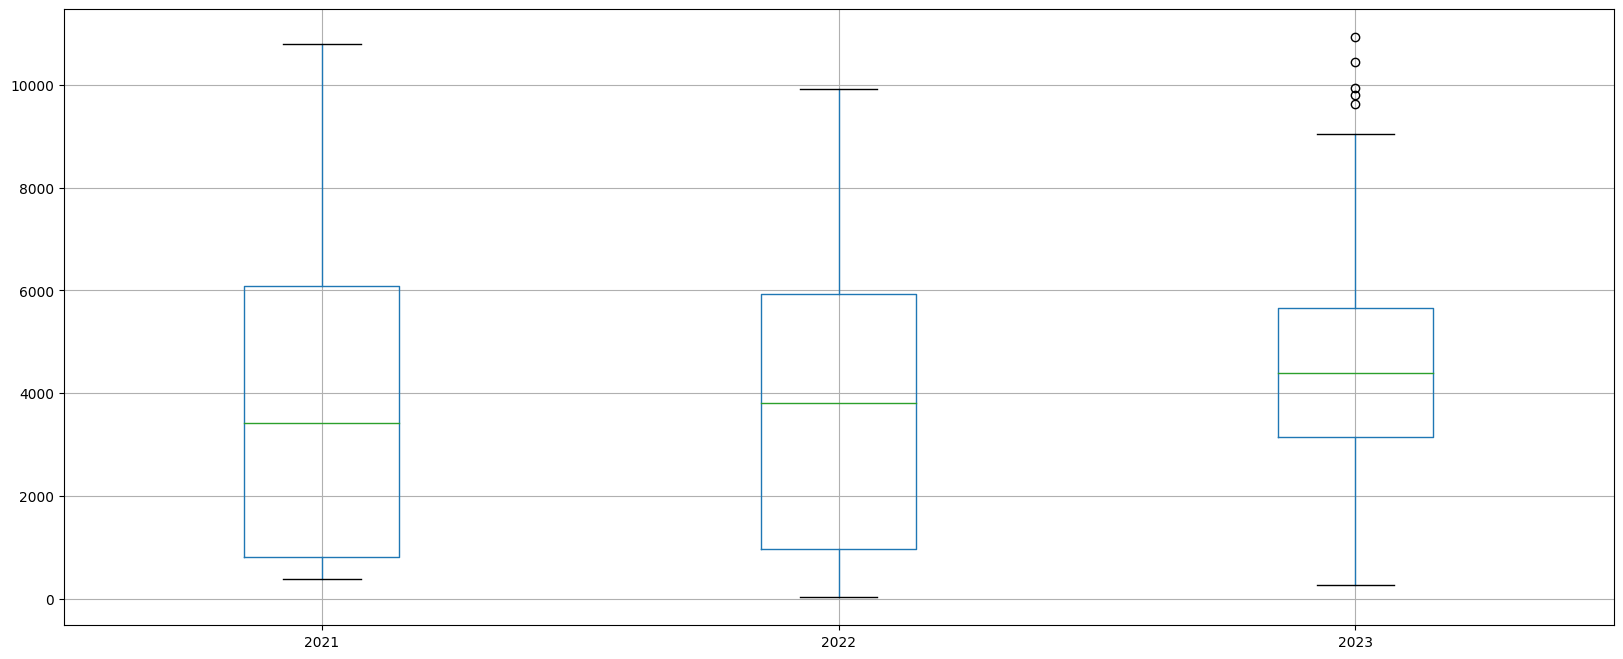

In [24]:
plt.figure(figsize = (20,8))
years.boxplot()

#### Lag plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

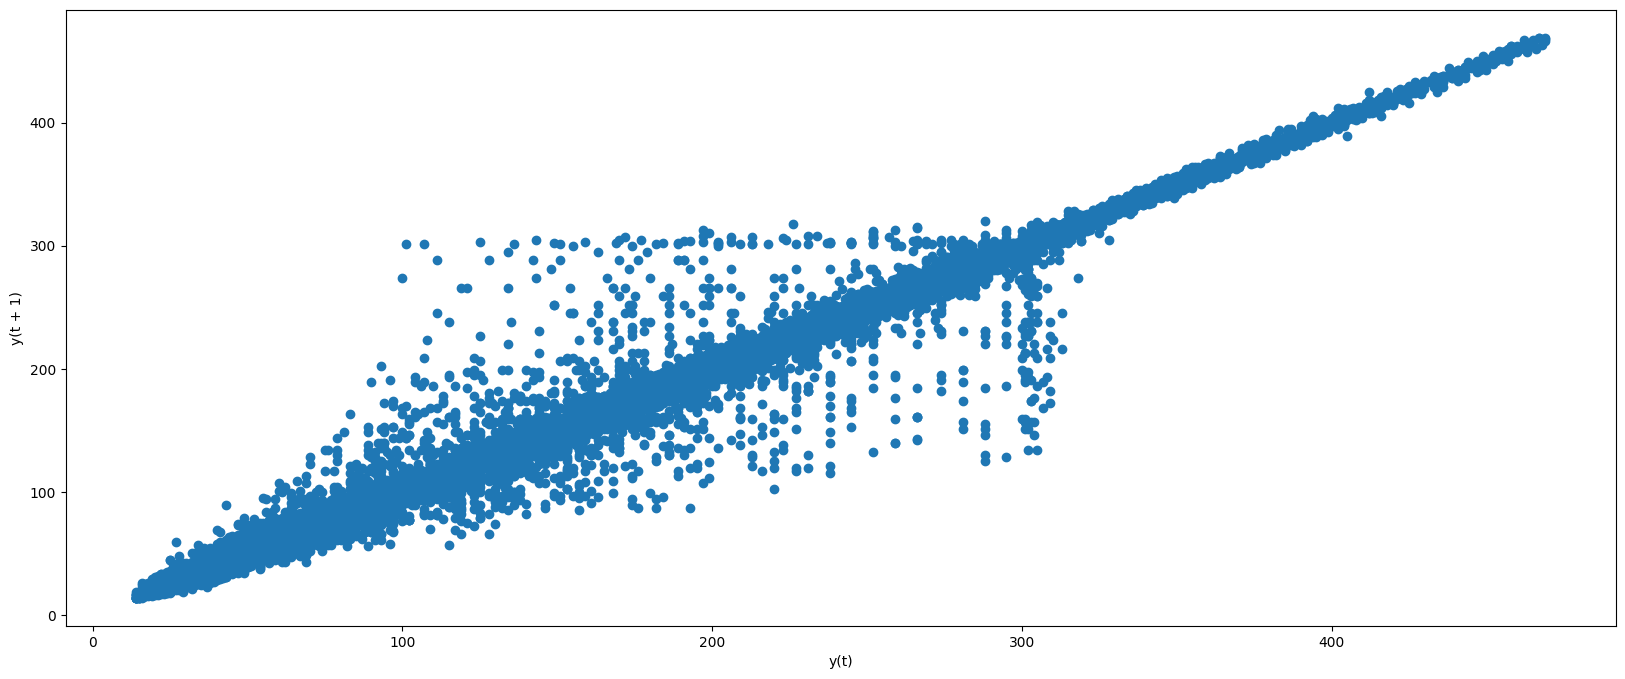

In [25]:
# create a scatter plot
plt.figure(figsize = (20,8))
pd.plotting.lag_plot(timeseriesdf)

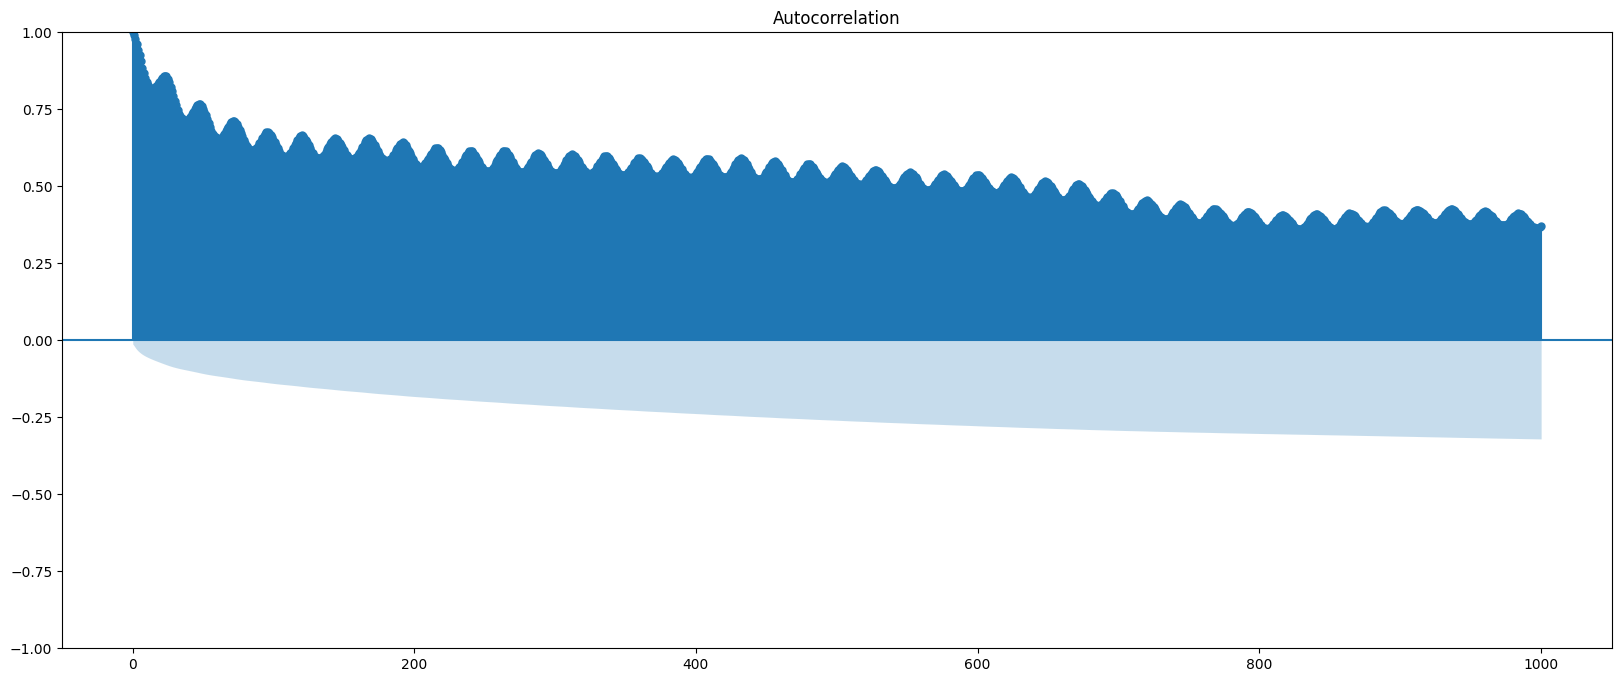

In [26]:
# create an autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(20,8))
plot_acf(timeseriesdf, lags=1000)
plt.show()

# Sampling and Transformation

In [27]:
#timeseriesdf = data[['AQI_calculated']]
#timeseriessq = data['AQI_calculated']
timeseriessq

Date
2021-01-01 15:00:00    208.0
2021-01-01 16:00:00    218.0
2021-01-01 17:00:00    229.0
2021-01-01 18:00:00    235.0
2021-01-01 19:00:00    236.0
                       ...  
2023-06-20 16:00:00     52.0
2023-06-20 17:00:00     49.0
2023-06-20 18:00:00     49.0
2023-06-20 19:00:00     49.0
2023-06-20 20:00:00     46.0
Name: AQI_calculated, Length: 21342, dtype: float64

#### Downsampling Data

In [28]:
series = timeseriessq.resample('D').mean()
series.head(25)

Date
2021-01-01    231.888889
2021-01-02    284.458333
2021-01-03    326.875000
2021-01-04    331.458333
2021-01-05    173.916667
2021-01-06    162.791667
2021-01-07    107.166667
2021-01-08     93.208333
2021-01-09    164.958333
2021-01-10    138.375000
2021-01-11    166.416667
2021-01-12    263.666667
2021-01-13    320.208333
2021-01-14    330.916667
2021-01-15    347.458333
2021-01-16    366.583333
2021-01-17    347.916667
2021-01-18    341.333333
2021-01-19    325.291667
2021-01-20    329.958333
2021-01-21    325.375000
2021-01-22    400.625000
2021-01-23    373.208333
2021-01-24    348.375000
2021-01-25    318.750000
Freq: D, Name: AQI_calculated, dtype: float64

In [29]:
series.shape
series = series.fillna(40)

<Axes: xlabel='Date'>

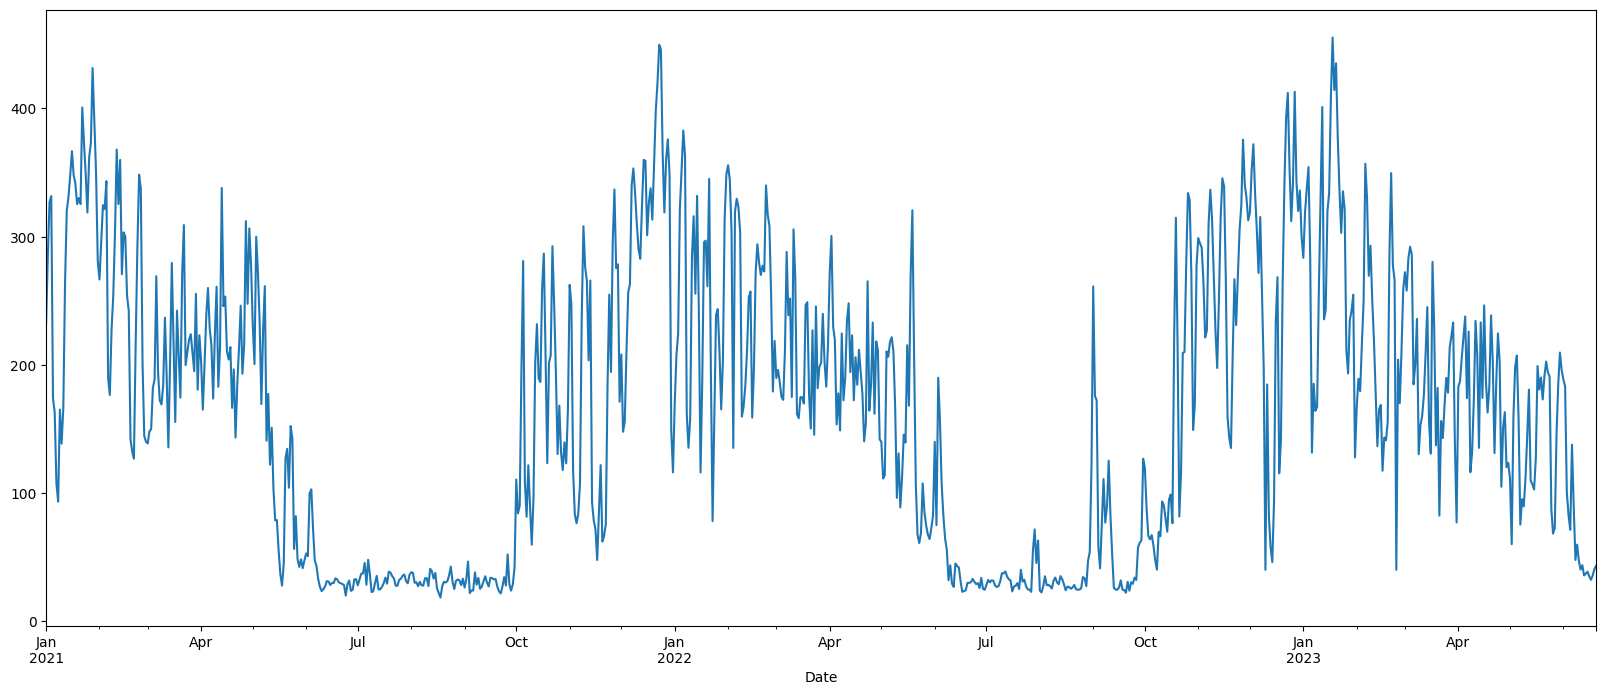

In [30]:
plt.rc("figure", figsize=(20,8))
series.plot()

#### Downsampling Data

In [31]:
# downsample to daily intervals
resample = timeseriesdf.resample('D')
downsampled = resample.mean()

In [32]:
downsampled.head()

,AQI_calculated
Date,
2021-01-01,231.888889
2021-01-02,284.458333
2021-01-03,326.875000
2021-01-04,331.458333
2021-01-05,173.916667


<Axes: xlabel='Date'>

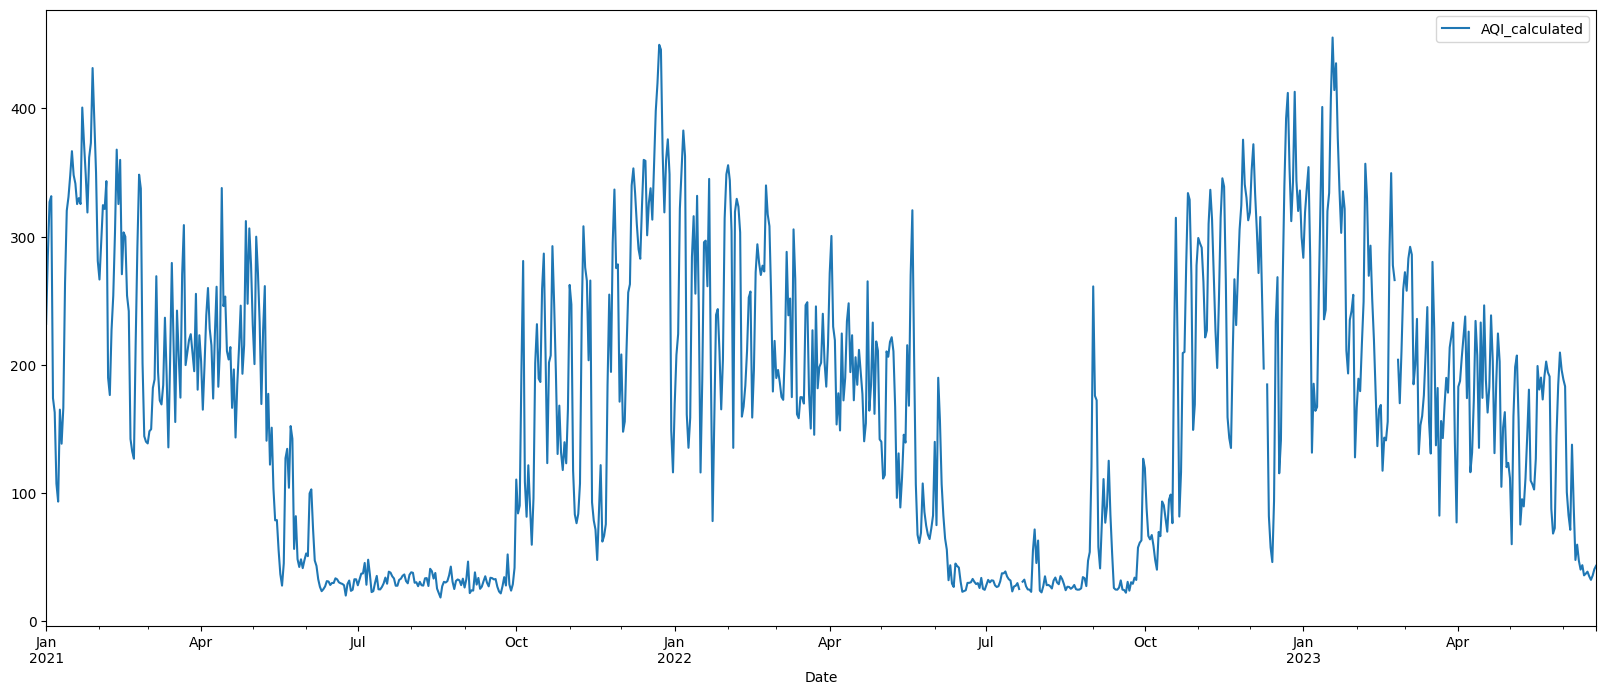

In [33]:
plt.rc("figure", figsize=(20,8))
downsampled.plot()

In [34]:
data = downsampled.copy()
data.reset_index(inplace=True)

In [35]:
data['AQI_calculated'] = data['AQI_calculated'].fillna(40)
print(data.isnull().sum())

Date              0
AQI_calculated    0
dtype: int64


# Forecasting - Model Based

In [36]:
heatmapdata = data[['Date','AQI_calculated']]
heatmapdata['Date'] = pd.to_datetime(heatmapdata['Date'])
heatmapdata

,Date,AQI_calculated
0,2021-01-01,231.888889
1,2021-01-02,284.458333
2,2021-01-03,326.875000
3,2021-01-04,331.458333
4,2021-01-05,173.916667
...,...,...
896,2023-06-16,34.958333
897,2023-06-17,32.166667
898,2023-06-18,35.500000
899,2023-06-19,40.500000


In [37]:
# Extracting Day, weekday name, month name, year from the Date column using
# Date functions from pandas

heatmapdata["month"] = heatmapdata['Date'].dt.strftime("%b") # month extraction
heatmapdata["year"] = heatmapdata['Date'].dt.strftime("%Y") # year extraction
heatmapdata["Day"] = heatmapdata['Date'].dt.strftime("%d") # Day extraction
heatmapdata["wkday"] = heatmapdata['Date'].dt.strftime("%A") # weekday extraction

heatmapdata

,Date,AQI_calculated,month,year,Day,wkday
0,2021-01-01,231.888889,Jan,2021,01,Friday
1,2021-01-02,284.458333,Jan,2021,02,Saturday
2,2021-01-03,326.875000,Jan,2021,03,Sunday
3,2021-01-04,331.458333,Jan,2021,04,Monday
4,2021-01-05,173.916667,Jan,2021,05,Tuesday
...,...,...,...,...,...,...
896,2023-06-16,34.958333,Jun,2023,16,Friday
897,2023-06-17,32.166667,Jun,2023,17,Saturday
898,2023-06-18,35.500000,Jun,2023,18,Sunday
899,2023-06-19,40.500000,Jun,2023,19,Monday


In [38]:
heatmap_y_month = pd.pivot_table(data = heatmapdata,
                                 values = "AQI_calculated",
                                 index = "year",
                                 columns = "month",
                                 aggfunc = "mean",
                                 fill_value=0)
heatmap_y_month1 = heatmap_y_month[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
heatmap_y_month1

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2021,293.841086,257.284226,204.311828,224.337500,126.951613,37.619444,32.442204,31.263441,30.598611,165.223118,174.084722,308.791667
2022,243.910122,260.059912,205.012097,200.162500,140.248656,51.773611,33.798036,32.619624,67.098611,143.900538,272.284722,261.616877
2023,290.090054,213.849508,193.546868,182.145833,145.747312,69.419643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='month', ylabel='year'>

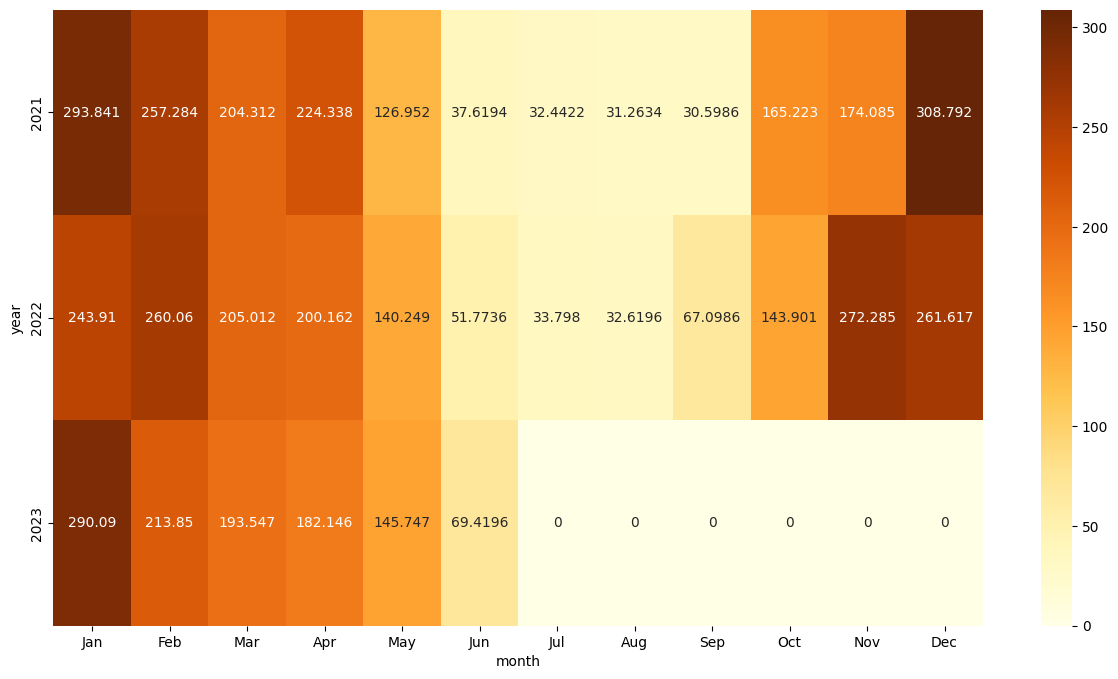

In [39]:
plt.figure(figsize=(15,8))
modelplot0 = sns.heatmap(heatmap_y_month1,
            annot=True,
            fmt="g",
            cmap = 'YlOrBr')
modelplot0

<Axes: xlabel='month', ylabel='AQI_calculated'>

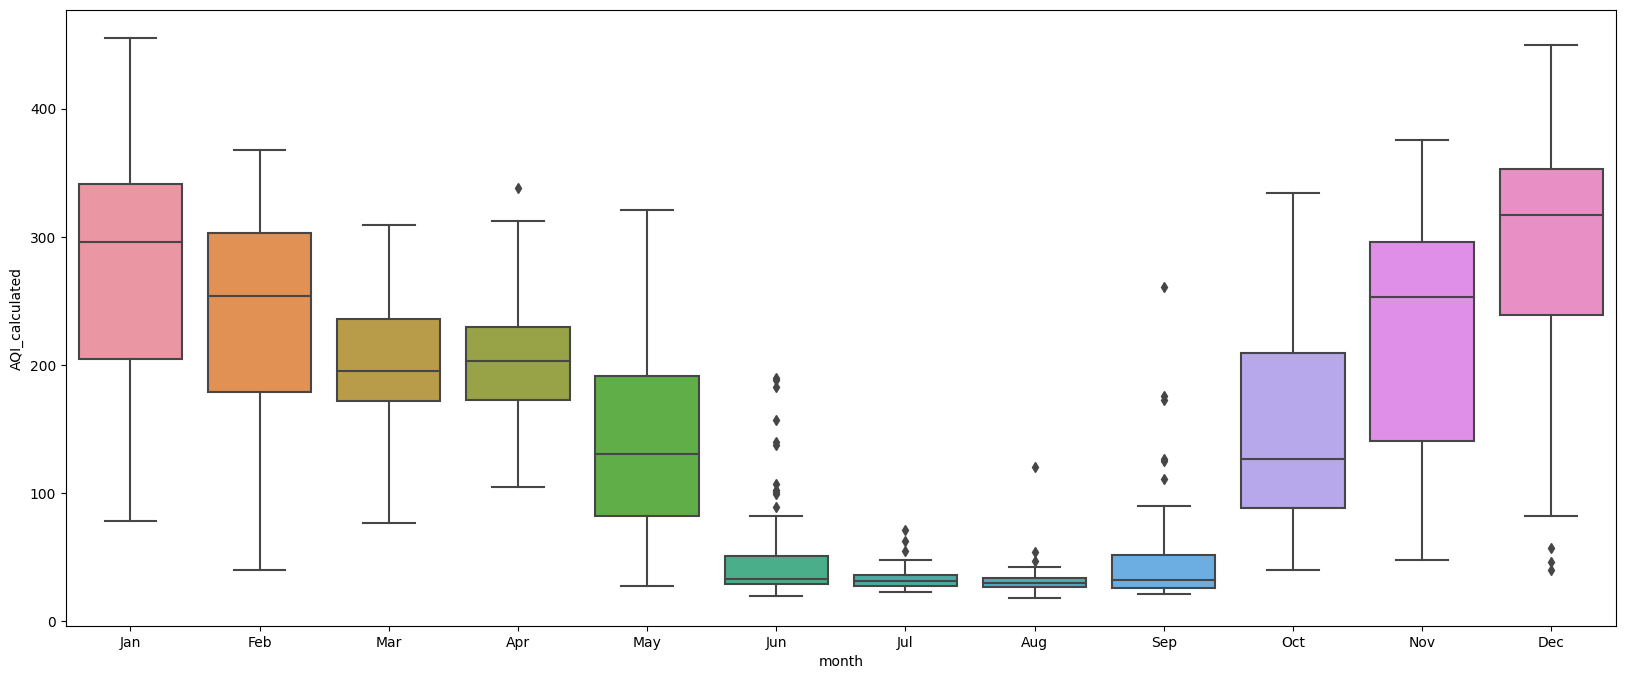

In [40]:
# Boxplot for every
plt.figure(figsize=(20,8))
modelplot1 = sns.boxplot(x="month",y="AQI_calculated",data=heatmapdata, order = ["Jan", "Feb","Mar", "Apr","May", "Jun","Jul", "Aug","Sep", "Oct","Nov", "Dec"])
modelplot1

#### Splitting data

In [41]:
data1 = heatmapdata.copy()
data1

,Date,AQI_calculated,month,year,Day,wkday
0,2021-01-01,231.888889,Jan,2021,01,Friday
1,2021-01-02,284.458333,Jan,2021,02,Saturday
2,2021-01-03,326.875000,Jan,2021,03,Sunday
3,2021-01-04,331.458333,Jan,2021,04,Monday
4,2021-01-05,173.916667,Jan,2021,05,Tuesday
...,...,...,...,...,...,...
896,2023-06-16,34.958333,Jun,2023,16,Friday
897,2023-06-17,32.166667,Jun,2023,17,Saturday
898,2023-06-18,35.500000,Jun,2023,18,Sunday
899,2023-06-19,40.500000,Jun,2023,19,Monday


In [42]:
data1['t'] = np.arange(1,data1.shape[0]+1)
data1['t_square'] = np.square(data1.t)
data1['log_AQI_calculated'] = np.log(data1.AQI_calculated)
data2 = pd.get_dummies(data1['month'])
data1 = pd.concat([data1, data2],axis=1)
data1 = data1.reset_index(drop = True)
data1

,Date,AQI_calculated,month,year,Day,wkday,t,t_square,log_AQI_calculated,Apr,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2021-01-01,231.888889,Jan,2021,01,Friday,1,1,5.446258,0,...,0,0,1,0,0,0,0,0,0,0
1,2021-01-02,284.458333,Jan,2021,02,Saturday,2,4,5.650587,0,...,0,0,1,0,0,0,0,0,0,0
2,2021-01-03,326.875000,Jan,2021,03,Sunday,3,9,5.789578,0,...,0,0,1,0,0,0,0,0,0,0
3,2021-01-04,331.458333,Jan,2021,04,Monday,4,16,5.803502,0,...,0,0,1,0,0,0,0,0,0,0
4,2021-01-05,173.916667,Jan,2021,05,Tuesday,5,25,5.158576,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,2023-06-16,34.958333,Jun,2023,16,Friday,897,804609,3.554157,0,...,0,0,0,0,1,0,0,0,0,0
897,2023-06-17,32.166667,Jun,2023,17,Saturday,898,806404,3.470931,0,...,0,0,0,0,1,0,0,0,0,0
898,2023-06-18,35.500000,Jun,2023,18,Sunday,899,808201,3.569533,0,...,0,0,0,0,1,0,0,0,0,0
899,2023-06-19,40.500000,Jun,2023,19,Monday,900,810000,3.701302,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
# Using 3/4th data for training and remaining for testing
test_size = round(0.25 * (data1.shape[0]+1))

Train = data1[:-test_size]
Test = data1[-test_size:]

In [44]:
Train

,Date,AQI_calculated,month,year,Day,wkday,t,t_square,log_AQI_calculated,Apr,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2021-01-01,231.888889,Jan,2021,01,Friday,1,1,5.446258,0,...,0,0,1,0,0,0,0,0,0,0
1,2021-01-02,284.458333,Jan,2021,02,Saturday,2,4,5.650587,0,...,0,0,1,0,0,0,0,0,0,0
2,2021-01-03,326.875000,Jan,2021,03,Sunday,3,9,5.789578,0,...,0,0,1,0,0,0,0,0,0,0
3,2021-01-04,331.458333,Jan,2021,04,Monday,4,16,5.803502,0,...,0,0,1,0,0,0,0,0,0,0
4,2021-01-05,173.916667,Jan,2021,05,Tuesday,5,25,5.158576,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,2022-11-02,294.708333,Nov,2022,02,Wednesday,671,450241,5.685986,0,...,0,0,0,0,0,0,0,1,0,0
671,2022-11-03,291.333333,Nov,2022,03,Thursday,672,451584,5.674468,0,...,0,0,0,0,0,0,0,1,0,0
672,2022-11-04,264.583333,Nov,2022,04,Friday,673,452929,5.578156,0,...,0,0,0,0,0,0,0,1,0,0
673,2022-11-05,221.291667,Nov,2022,05,Saturday,674,454276,5.399482,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
Test

,Date,AQI_calculated,month,year,Day,wkday,t,t_square,log_AQI_calculated,Apr,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
675,2022-11-07,309.833333,Nov,2022,07,Monday,676,456976,5.736035,0,...,0,0,0,0,0,0,0,1,0,0
676,2022-11-08,336.458333,Nov,2022,08,Tuesday,677,458329,5.818474,0,...,0,0,0,0,0,0,0,1,0,0
677,2022-11-09,313.458333,Nov,2022,09,Wednesday,678,459684,5.747666,0,...,0,0,0,0,0,0,0,1,0,0
678,2022-11-10,269.666667,Nov,2022,10,Thursday,679,461041,5.597187,0,...,0,0,0,0,0,0,0,1,0,0
679,2022-11-11,226.250000,Nov,2022,11,Friday,680,462400,5.421641,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,2023-06-16,34.958333,Jun,2023,16,Friday,897,804609,3.554157,0,...,0,0,0,0,1,0,0,0,0,0
897,2023-06-17,32.166667,Jun,2023,17,Saturday,898,806404,3.470931,0,...,0,0,0,0,1,0,0,0,0,0
898,2023-06-18,35.500000,Jun,2023,18,Sunday,899,808201,3.569533,0,...,0,0,0,0,1,0,0,0,0,0
899,2023-06-19,40.500000,Jun,2023,19,Monday,900,810000,3.701302,0,...,0,0,0,0,1,0,0,0,0,0


### Trying basic models

In [46]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('AQI_calculated~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(pred_linear))**2))
rmse_linear

150.86836759435377

In [47]:
#Exponential
Exp = smf.ols('log_AQI_calculated~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

172.27335810532315

In [48]:
#Quadratic
Quad = smf.ols('AQI_calculated~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(pred_Quad))**2))
rmse_Quad

136.59997562542304

In [49]:
#Additive seasonality
add_sea = smf.ols('AQI_calculated~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(pred_add_sea))**2))
rmse_add_sea

81.46465638883029

In [50]:
#Additive Seasonality Quadratic
add_sea_Quad = smf.ols('AQI_calculated~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

91.97459082130804

In [51]:
##Multiplicative Seasonality
Mul_sea = smf.ols('log_AQI_calculated~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

84.80114234454325

In [52]:
#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_AQI_calculated~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['AQI_calculated'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

86.11633873833804

In [53]:
#Compare the results
datamodel = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(datamodel)
table = table_rmse.sort_values(['RMSE_Values'],ignore_index = True)
table

,MODEL,RMSE_Values
0,rmse_add_sea,81.464656
1,rmse_Mult_sea,84.801142
2,rmse_Mult_add_sea,86.116339
3,rmse_add_sea_quad,91.974591
4,rmse_Quad,136.599976
5,rmse_linear,150.868368
6,rmse_Exp,172.273358


In [54]:
bestmodel = table.iloc[0,0]
bestmodel

if bestmodel == "rmse_linear" :
  formula = 'AQI_calculated~t'

if bestmodel == "rmse_Exp":
  formula = 'log_AQI_calculated~t'

if bestmodel == "rmse_Quad" :
  formula = 'AQI_calculated~t+t_square'

if bestmodel == "rmse_add_sea":
  formula = 'AQI_calculated~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'

if bestmodel == "rmse_add_sea_quad":
  formula = 'AQI_calculated~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'

if bestmodel == "rmse_Mult_sea":
  formula = 'log_AQI_calculated~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'

if bestmodel == "rmse_Mult_add_sea":
  formula = 'log_AQI_calculated~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'

formula

'AQI_calculated~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov'

In [55]:
#Build the model on entire data set
model_full = smf.ols(formula,data=data1).fit()

In [56]:
pred_new  = pd.Series(model_full.predict(data1))
pred_new

0      275.947087
1      275.947087
2      275.947087
3      275.947087
4      275.947087
          ...    
896     50.877307
897     50.877307
898     50.877307
899     50.877307
900     50.877307
Length: 901, dtype: float64

In [57]:
if bestmodel == ("rmse_Exp" or "rmse_Mult_sea" or "rmse_Mult_add_sea"):
  data1["forecasted_AQI_calculated"] = pd.Series(np.exp(pred_new))
else:
  data1["forecasted_AQI_calculated"] = pd.Series((pred_new))

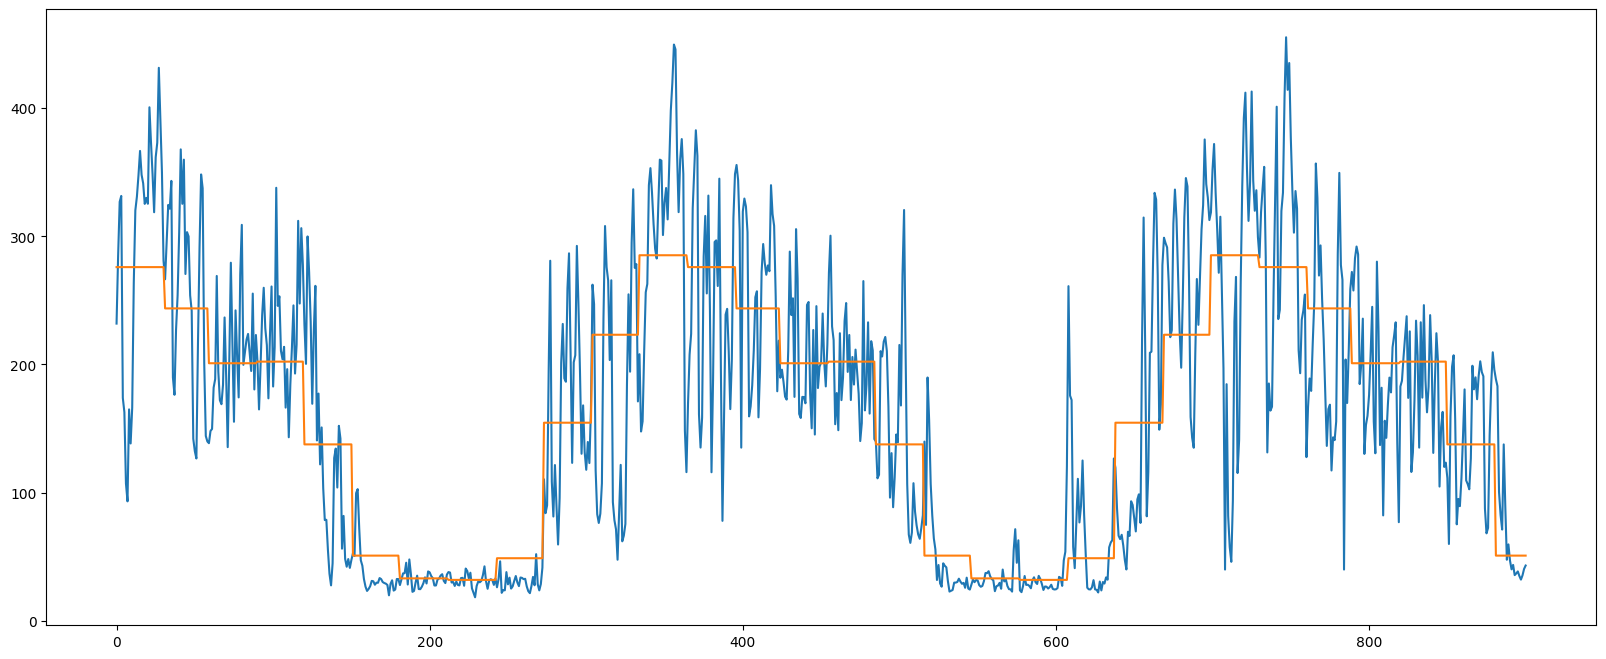

In [58]:
plt.figure(figsize = (20,8))

plt.plot(data1[['AQI_calculated','forecasted_AQI_calculated']].reset_index(drop=True))

# Forecasting - Data Driven

In [59]:
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#### Moving Average

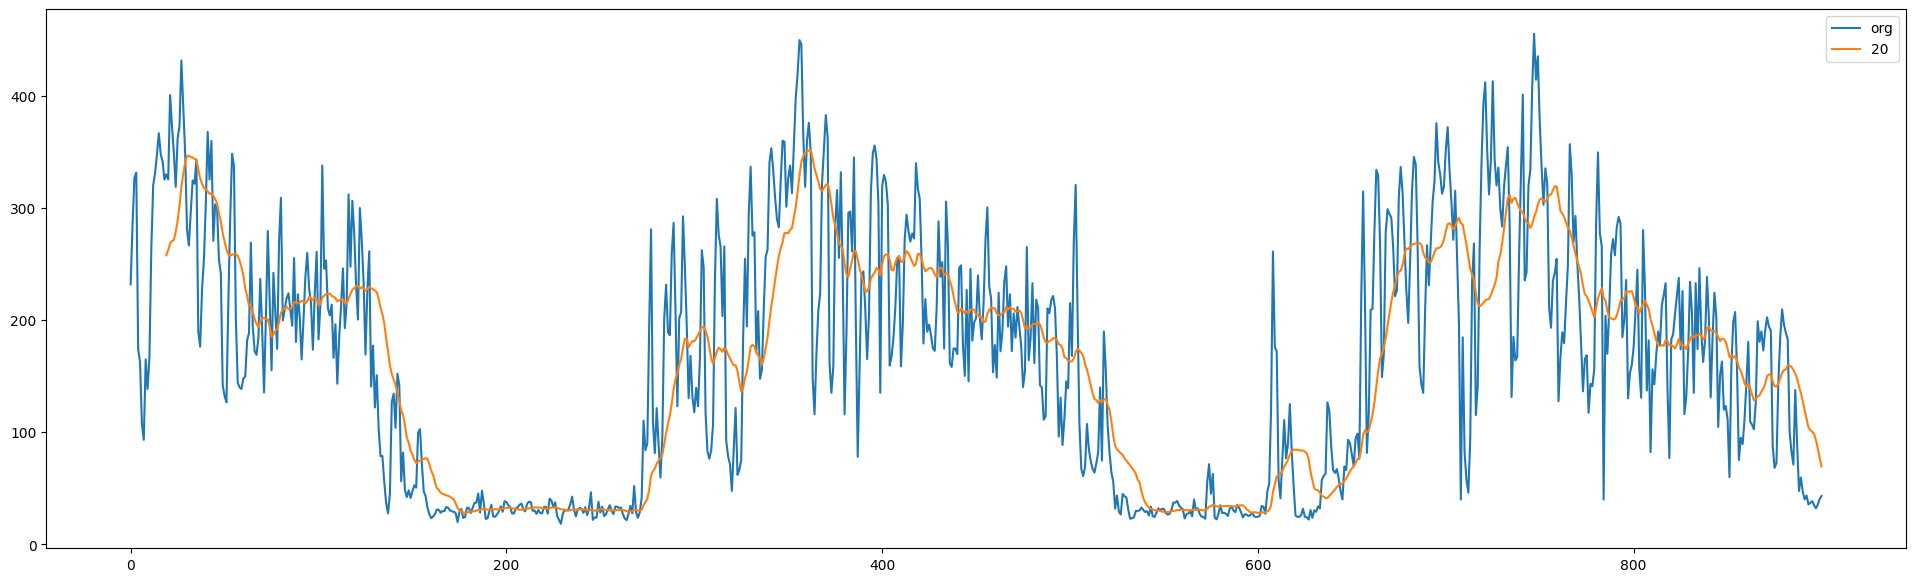

In [60]:
x=20

plt.figure(figsize=(24,7))
data1['AQI_calculated'].plot(label="org")
data1["AQI_calculated"].rolling(x).mean().plot(label=str(x))
plt.legend(loc='best')

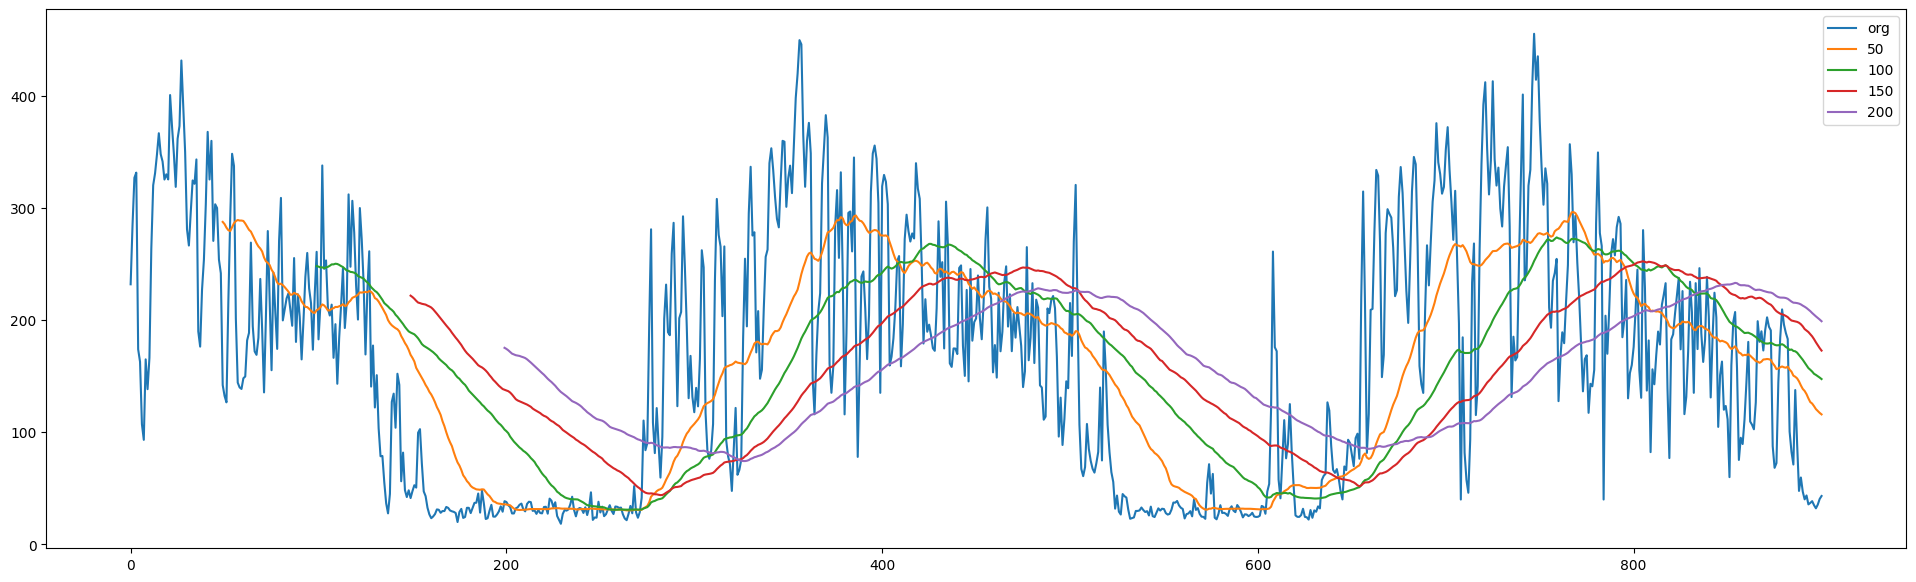

In [61]:
fig = plt.figure(figsize=(24,7))
data1['AQI_calculated'].plot(label="org")
for i in range(50,201,50):
    data1["AQI_calculated"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')



#### Time series decomposition plot


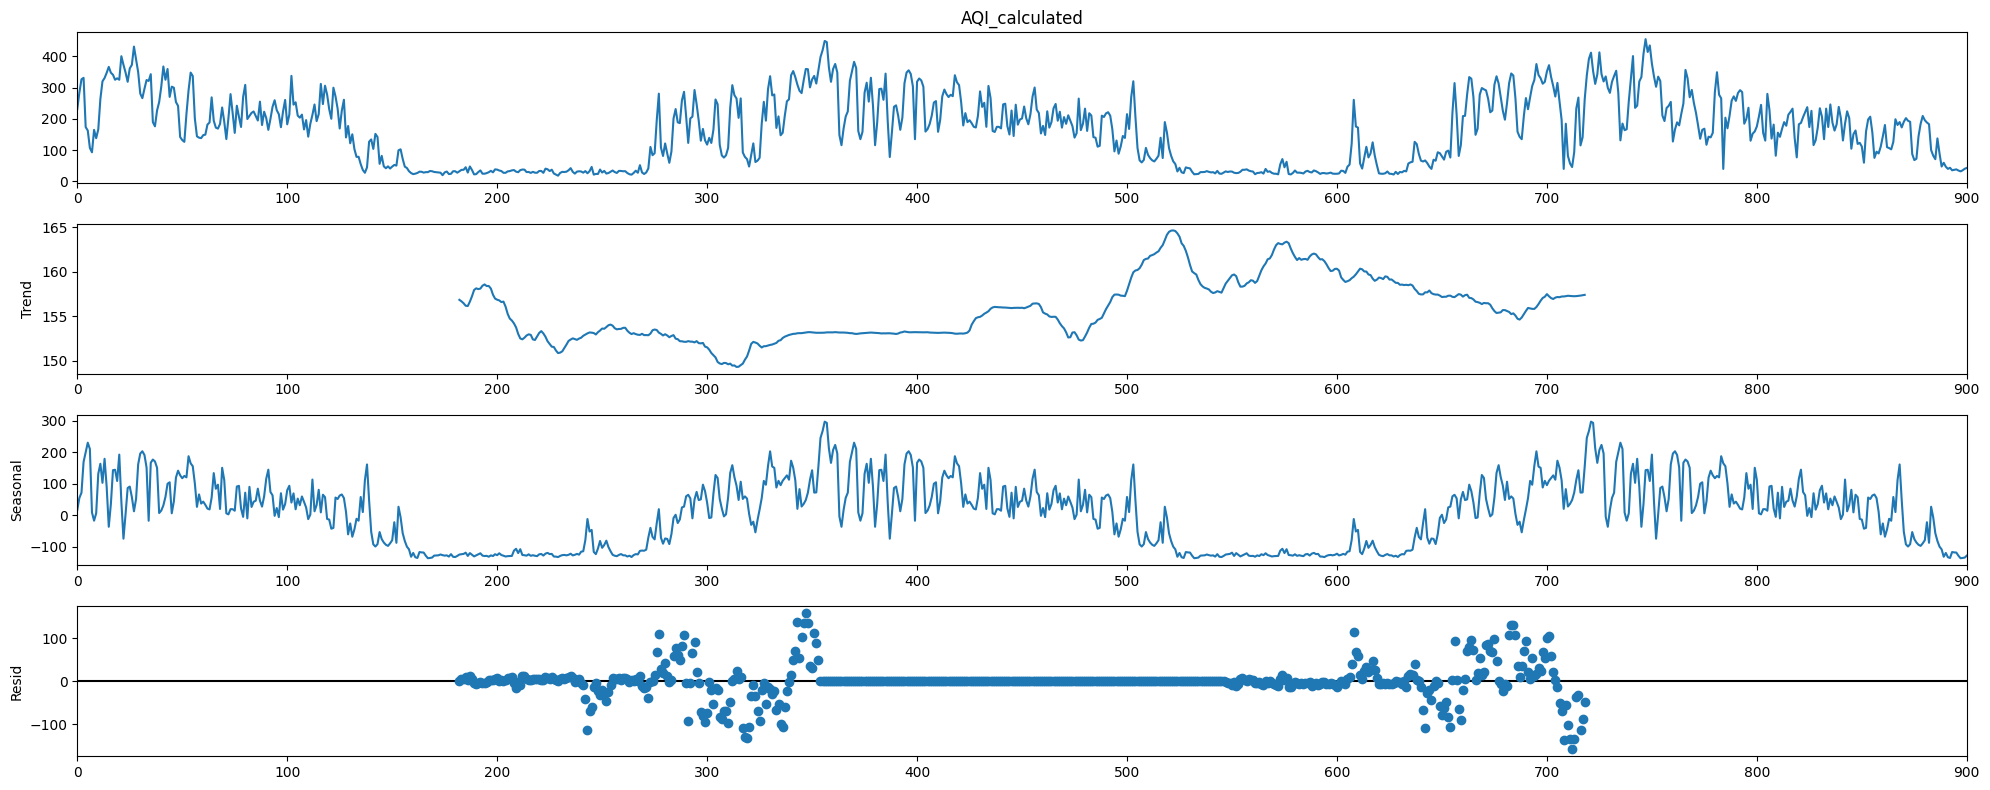

In [62]:
decompose_ts_add = seasonal_decompose(data1['AQI_calculated'], period = 365)
decompose_ts_add.plot()

plt.show()

### Evaluation Metric RMSE

In [63]:
def RMSE(pred,org):
  MSE = np.square(np.subtract(org,pred)).mean()
  return np.sqrt(MSE)

### Simple Exponential Method


In [64]:
ses_model = SimpleExpSmoothing(Train["AQI_calculated"]).fit(smoothing_level=1)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmseses = RMSE(pred_ses,Test.AQI_calculated)

### Holt method

In [65]:
# Holt method
hw_model = Holt(Train["AQI_calculated"]).fit(smoothing_level=0.9, smoothing_slope=0.1)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmsehw = RMSE(pred_hw,Test.AQI_calculated)

### Holts winter exponential smoothing with additive seasonality and additive trend


In [66]:
hwe_model_add_add = ExponentialSmoothing(Train["AQI_calculated"],seasonal="add",trend="add",seasonal_periods=90).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmsehwaa = RMSE(pred_hwe_add_add,Test.AQI_calculated)

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [67]:
hwe_model_mul_add = ExponentialSmoothing(Train["AQI_calculated"],seasonal="mul",trend="add",seasonal_periods=90).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmsehwma = RMSE(pred_hwe_mul_add,Test.AQI_calculated)

### Final Model by combining train and test

In [68]:
#Compare the results
datamodel1 = {"MODEL":pd.Series(["rmse_ses","rmse_hw","rmse_hwe_add_add","rmse_hwe_mul_add"]),"RMSE_Values":pd.Series([rmseses,rmsehw,rmsehwaa,rmsehwma])}
table_rmse1 = pd.DataFrame(datamodel1)
table1 = table_rmse1.sort_values(['RMSE_Values'],ignore_index = True)
table1

,MODEL,RMSE_Values
0,rmse_hwe_mul_add,90.129812
1,rmse_hw,97.274258
2,rmse_ses,97.616109
3,rmse_hwe_add_add,99.784937


In [69]:
bestmodel1 = table1.iloc[0,0]
bestmodel1

if bestmodel1 == "rmse_hwe_add_add" :
  formula1 = ExponentialSmoothing(data["AQI_calculated"],seasonal="add",trend="add",seasonal_periods=90).fit()

if bestmodel1 == "rmse_hwe_mul_add":
  formula1 = ExponentialSmoothing(data["AQI_calculated"],seasonal="mul",trend="add",seasonal_periods=90).fit()

if bestmodel1 == "rmse_ses" :
  formula1 = SimpleExpSmoothing(data["AQI_calculated"]).fit(smoothing_level=1)

if bestmodel1 == "rmse_hw":
  formula1 = Holt(data["AQI_calculated"]).fit(smoothing_level=0.9, smoothing_slope=0.1)


In [70]:
#Forecasting for next 12 time periods
forecasted = formula1.forecast(30)

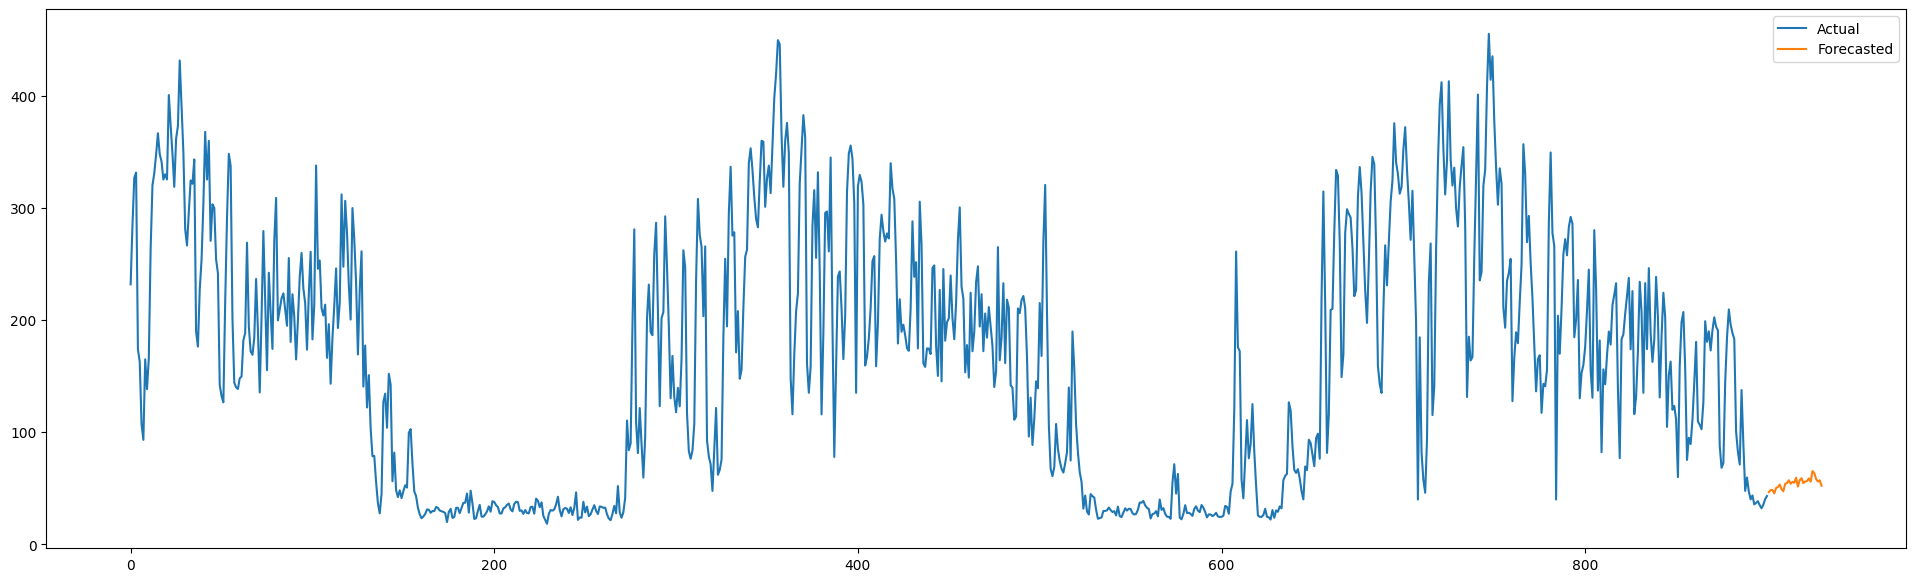

In [71]:
dataplot2 = plt.figure(figsize=(24,7))
plt.plot(data1.AQI_calculated, label = "Actual")
plt.plot(forecasted, label = "Forecasted")
plt.legend()

# Forecasting using ARIMA,SARIMA and SARIMAX model

### Checking if the data is stationary or not

In [72]:
data

,Date,AQI_calculated
0,2021-01-01,231.888889
1,2021-01-02,284.458333
2,2021-01-03,326.875000
3,2021-01-04,331.458333
4,2021-01-05,173.916667
...,...,...
896,2023-06-16,34.958333
897,2023-06-17,32.166667
898,2023-06-18,35.500000
899,2023-06-19,40.500000


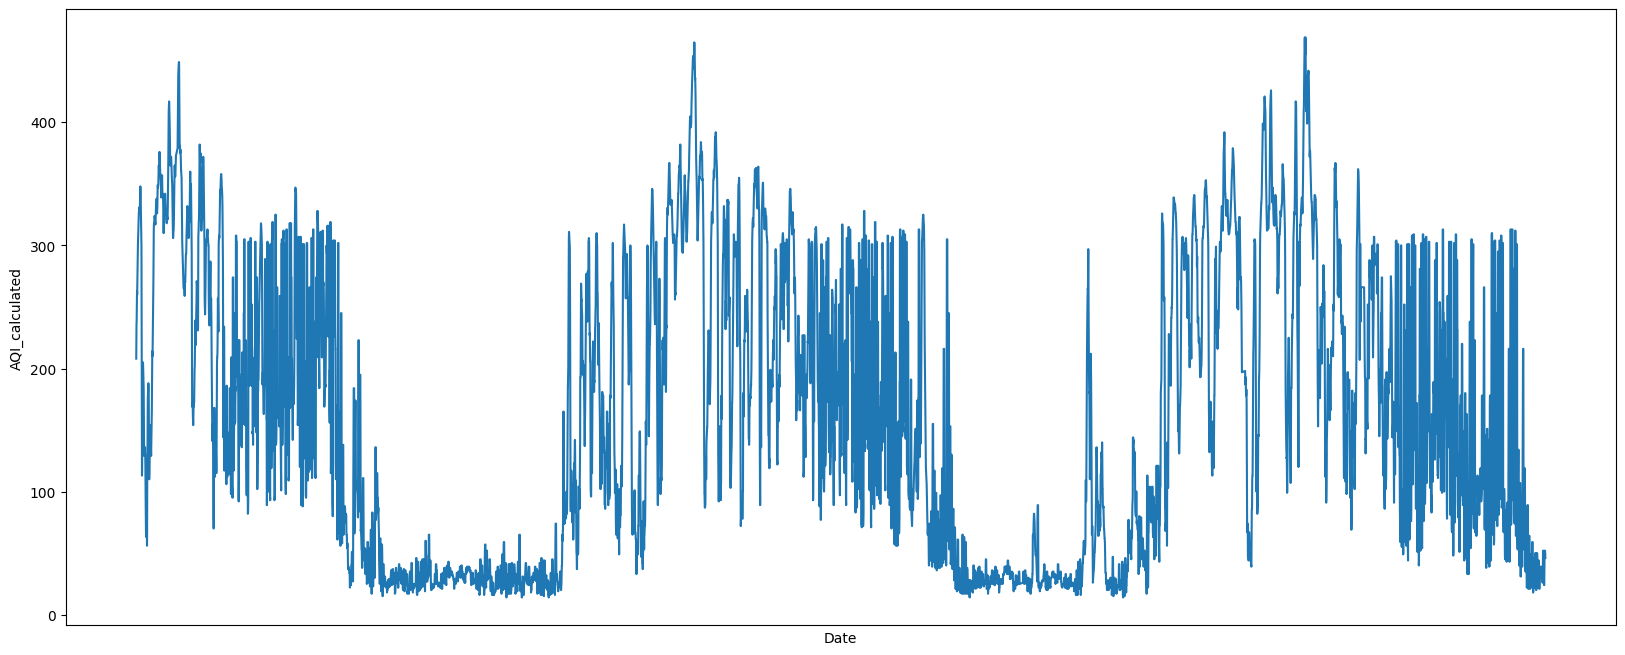

In [73]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

fig=plt.figure(figsize=(20,8))
sns.lineplot(data=timeseriesdf,x='Date',y='AQI_calculated')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.show()

### Augmented Dickey-Fuller Test

In [74]:
result=adfuller (timeseriesdf['AQI_calculated'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -6.006840
p-value: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Kwiatkowski Phillips Schmidt Shin (KPSS) test

In [75]:
result_kpss_ct=kpss(timeseriesdf['AQI_calculated'],regression="c")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.872374
p-value: 0.010000
Critical values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:         AQI_calculated   No. Observations:                  901
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4762.980
Date:                Tue, 20 Jun 2023   AIC                           9537.961
Time:                        15:02:08   BIC                           9566.775
Sample:                    01-01-2021   HQIC                          9548.968
                         - 06-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1282      0.025     -5.026      0.000      -0.178      -0.078
ar.L2         -0.2290      0.028     -8.168      0.000      -0.284      -0.174
ar.L3         -0.1772      0.031     -5.649      0.0

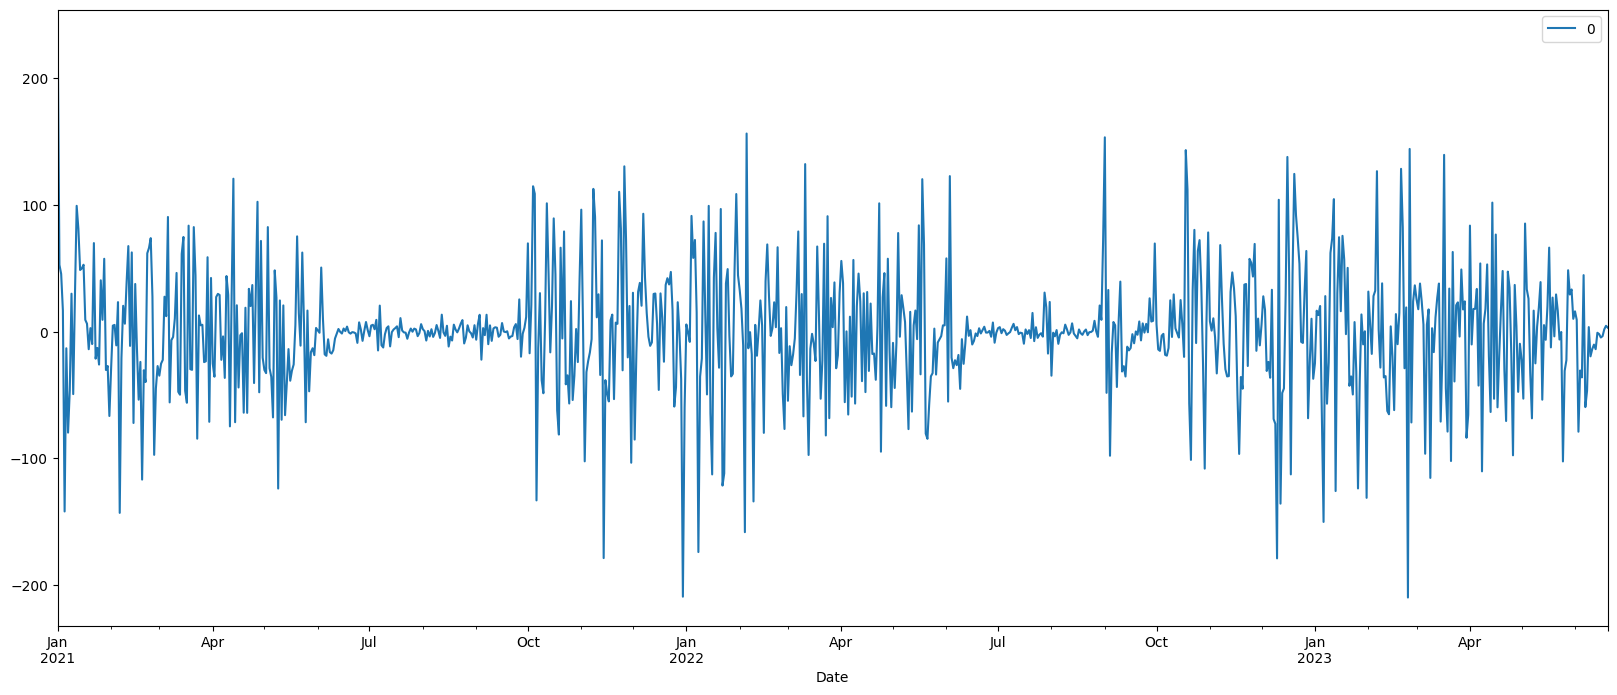

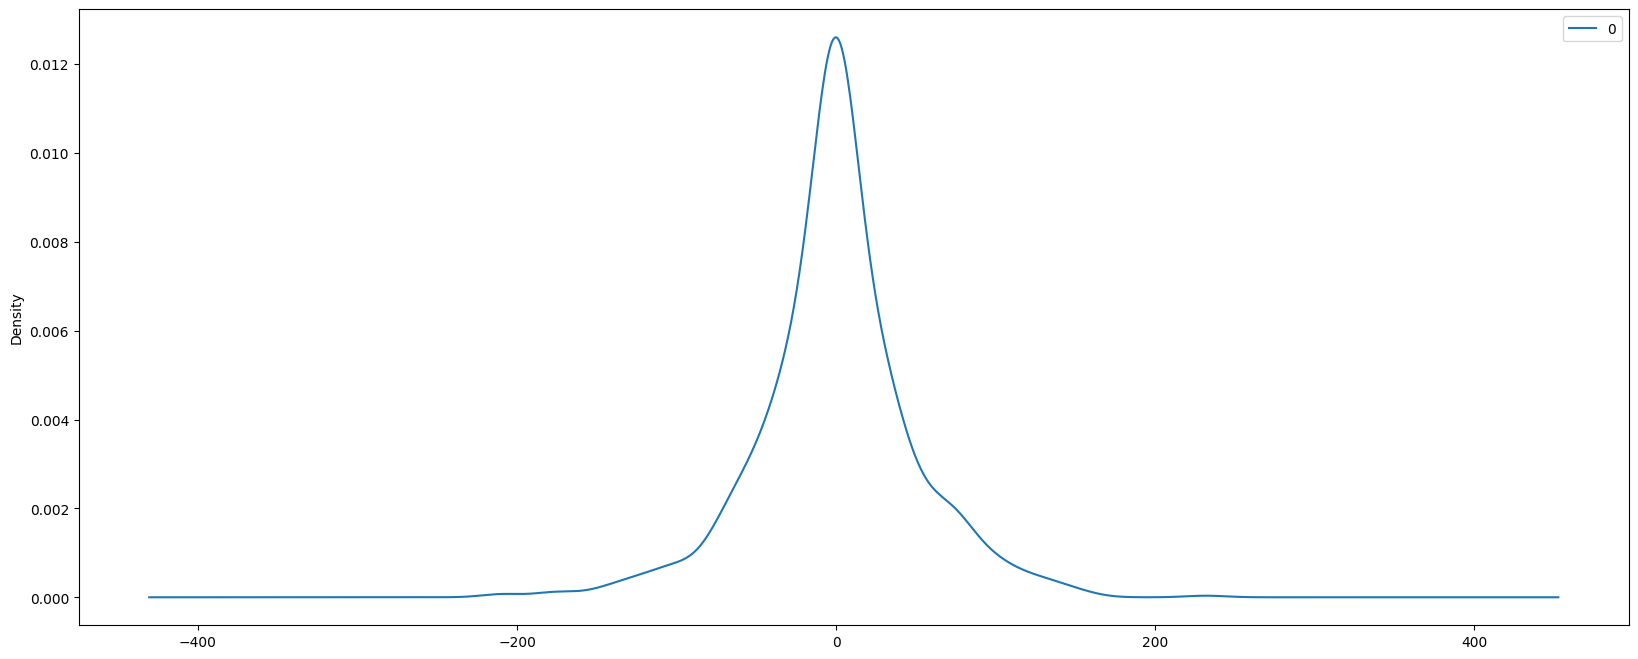

                0
count  901.000000
mean    -0.140946
std     48.721381
min   -209.696291
25%    -22.578241
50%     -0.371142
75%     23.239307
max    231.888889


In [76]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predicted=27.605764, expected=26.625000
predicted=27.765286, expected=25.208333
predicted=26.363744, expected=26.250000
predicted=26.695921, expected=28.166667
predicted=27.531005, expected=24.875000
predicted=24.973424, expected=24.458333
predicted=24.996612, expected=24.583333
predicted=24.708649, expected=25.541667
predicted=25.722883, expected=34.291667
predicted=33.429309, expected=33.458333
predicted=31.456978, expected=27.291667
predicted=26.752489, expected=47.125000
predicted=44.414780, expected=53.875000
predicted=48.277922, expected=120.375000
predicted=108.022700, expected=261.083333
predicted=225.088355, expected=175.750000
predicted=140.358949, expected=172.250000
predicted=158.358682, expected=57.750000
predicted=53.926230, expected=41.083333
predicted=63.571732, expected=76.416667
predicted=107.057741, expected=110.791667
predicted=121.590824, expected=76.750000
predicted=87.230859, expected=89.625000
predicted=86.261945, expected=125.083333
predicted=112.039015, expect

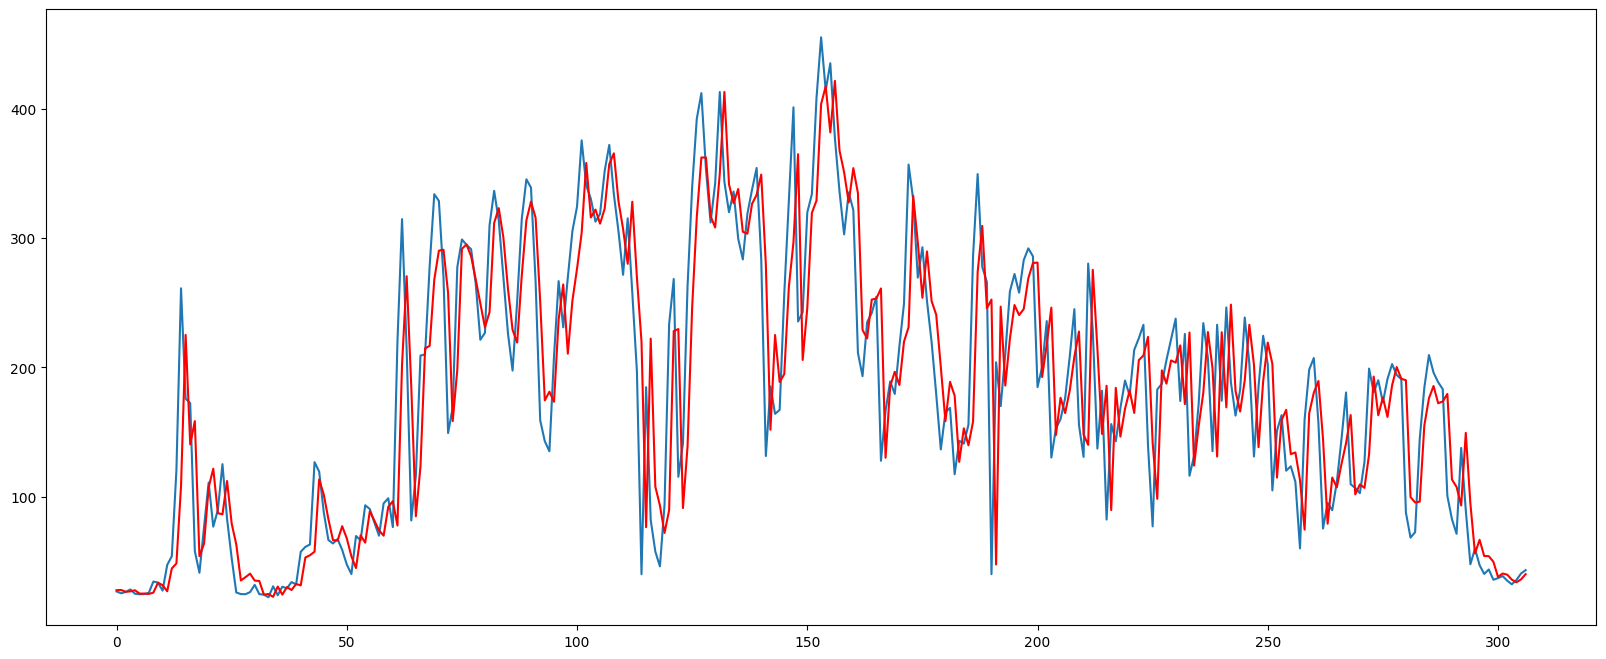

In [77]:
# split into train and test sets
from math import sqrt
from sklearn.metrics import mean_squared_error
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [92]:
model_fit.forecast(steps = 3)

array([40.00810765, 39.18127938, 38.26795075])

In [93]:
import pickle
pickle.dump(model_fit, open('modelarima.pkl', 'wb'))
pickled_model = pickle.load(open('modelarima.pkl', 'rb'))
pickled_model.forecast(steps = 3)


array([40.00810765, 39.18127938, 38.26795075])

#*Multiple Time Series Algorithms at once*

In [79]:
data

,Date,AQI_calculated
0,2021-01-01,231.888889
1,2021-01-02,284.458333
2,2021-01-03,326.875000
3,2021-01-04,331.458333
4,2021-01-05,173.916667
...,...,...
896,2023-06-16,34.958333
897,2023-06-17,32.166667
898,2023-06-18,35.500000
899,2023-06-19,40.500000


In [80]:
!pip install pycaret --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [81]:
from pycaret.time_series import TSForecastingExperiment

In [82]:
exp = TSForecastingExperiment()
exp.setup(data=series, fh=10, session_id=42, fig_kwargs = {"template": "simple_white","hoverinfo":"none"})

,Description,Value
0,session_id,42
1,Target,AQI_calculated
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(901, 1)"
5,Transformed data shape,"(901, 1)"
6,Transformed train set shape,"(891, 1)"
7,Transformed test set shape,"(10, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


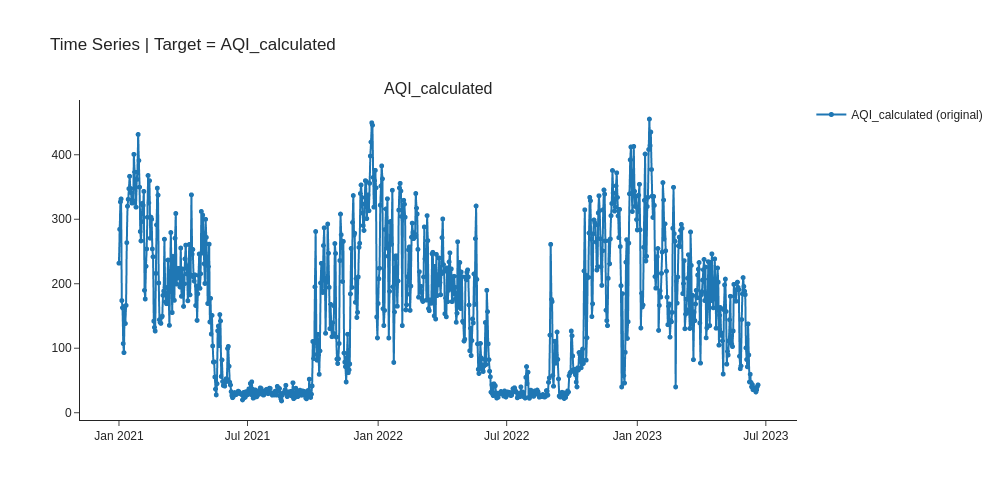

In [83]:
exp.plot_model(plot="ts",fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":10})

In [94]:
exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.6027,0.5490,45.1065,55.6438,0.4373,0.3679,-0.4104,4.5633
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.6321,0.5436,47.2792,55.0660,0.5416,0.3724,-0.5175,1.3400
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6321,0.5436,47.2786,55.0630,0.5416,0.3724,-0.5173,0.8467
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6321,0.5436,47.2792,55.0660,0.5416,0.3724,-0.5175,1.5600
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6321,0.5436,47.2787,55.0623,0.5417,0.3724,-0.5173,0.8533
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6321,0.5436,47.2786,55.0625,0.5416,0.3724,-0.5173,0.8533
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6337,0.5436,47.3998,55.0662,0.5422,0.3730,-0.5178,0.8467
snaive,Seasonal Naive Forecaster,0.6448,0.5906,48.2722,59.8760,0.4898,0.3747,-0.7725,0.0433
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6522,0.5632,48.8019,57.0682,0.5309,0.3881,-0.6742,1.6367
theta,Theta Forecaster,0.6635,0.5854,49.6285,59.2863,0.5840,0.3845,-0.7020,0.0833


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

ARIMA(seasonal_order=(0, 1, 0, 27))

# Deployment

In [ ]:
pip freeze